#Section.1_Project [ 다음 분기에 어떤 게임을 설계해야 할까? ]  

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, Normalizer
from sklearn.decomposition import PCA
from scipy import stats
from sklearn import decomposition

##1. 데이터 불러오기

In [2]:
data = pd.read_csv('vgames2.csv')
df = pd.DataFrame(data)
df = df.iloc[:, 1:]
print(df.isna().sum(), df.shape) # 결측치 확인

Name             0
Platform         0
Year           271
Genre           50
Publisher       58
NA_Sales         0
EU_Sales         0
JP_Sales         0
Other_Sales      0
dtype: int64 (16598, 9)


##2.EDA
- 년도 : 천단위가 아닌 십단위, 일단위에 대해서
- 출고량 : K, M 단위 통일
- 결측치 처리 : 제작사, 장르에 대해서는 Unknown, 년도에 대해서는 해당
행을 삭제하였다.
- 중복데이터 확인 및 제거
- 이상치 확인 및 제거

In [3]:
# 결측치 처리

df['Publisher'].fillna('Unknown', inplace = True)
df['Genre'].fillna('Unknown', inplace = True) 
df.dropna(inplace = True)

# 출고량에 대해서 M이 있으면, 수치만 가져오고 K가 있으면, 0.001을 곱하는 것으로 수치를 맞추었다

def ridString(string):
  if string.__contains__('M') == True:
    return float(string.replace('M',''))
  elif string.__contains__('K') == True:
   return float(string.replace('K','')) * 0.001
  else:
    return float(string)

# 출고량에 대해서 위 함수를 적용

df['NA_Sales'] = df['NA_Sales'].apply(ridString)
df['EU_Sales'] = df['EU_Sales'].apply(ridString)
df['JP_Sales'] = df['JP_Sales'].apply(ridString)
df['Other_Sales'] = df['Other_Sales'].apply(ridString)

# 년도를 4숫자로 표현하기 위해 30을 기준으로 하위는 2000을 상위는 1900을 더해주었다.

df_19 = df[(df['Year'] >= 30) & (df['Year'] <= 100)]
df_19['Year'] = df_19['Year'] + 1900
df_20 = df[df['Year'] <= 30]
df_20['Year'] = df_20['Year'] + 2000
df[(df['Year'] >= 30) & (df['Year'] <= 100)] = df_19
df[df['Year'] <= 20] = df_20

# 비교가 쉽게 총 출고량 컬럼을 새로 만들어주었다.

df['sum'] = df.loc[:,'NA_Sales':'Other_Sales'].sum(axis = 1)
df.reset_index(drop = True, inplace = True)

# Year Int화

df['Year'] = df['Year'].astype(int)

# info, unique를 통해 원하는 형태의 데이터를 갖음을 확인하였다.

print(df.info(),df['Year'].unique())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16327 entries, 0 to 16326
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Name         16327 non-null  object 
 1   Platform     16327 non-null  object 
 2   Year         16327 non-null  int64  
 3   Genre        16327 non-null  object 
 4   Publisher    16327 non-null  object 
 5   NA_Sales     16327 non-null  float64
 6   EU_Sales     16327 non-null  float64
 7   JP_Sales     16327 non-null  float64
 8   Other_Sales  16327 non-null  float64
 9   sum          16327 non-null  float64
dtypes: float64(5), int64(1), object(4)
memory usage: 1.2+ MB
None [2008 2009 2010 2005 2011 2007 2001 2003 2006 2014 2015 2002 1997 2013
 1996 2004 2000 1984 1998 2016 1985 1999 1995 1993 2012 1987 1982 1994
 1990 1992 1991 1983 1988 1981 1989 1986 2017 1980 2020]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [4]:
# 중복된 데이터 확인

df[df.duplicated()]

,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,sum


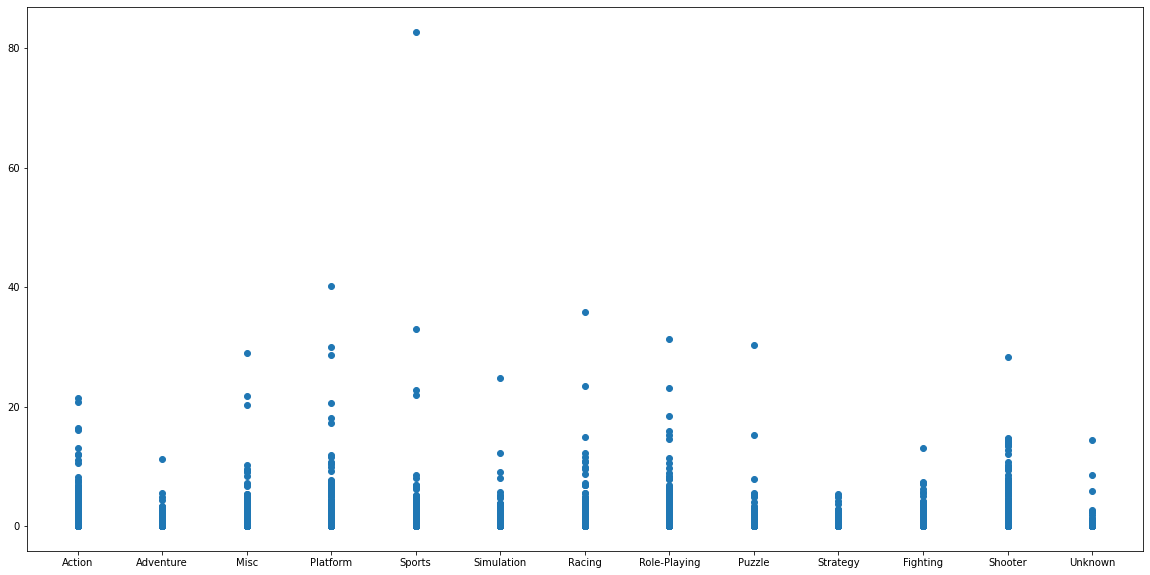

In [5]:
plt.figure(figsize = (20,10))
plt.scatter(df['Genre'],df['sum'])

In [6]:
df[df['sum'] >= 70]
df.drop([2867], inplace = True) 

# 가장 상위에 가장 큰 분산을 갖는 하나의 데이터만 이상치로 여겼다. 
# 이와 같이 최상위 데이터 하나에 대해 이상치로 처리한 이유는 후에 있을 상위 게임들에 대한 분석에 있어서 샘플수가 줄어듬을 감안하여, 해당 데이터가 큰 영향을 줄 것이라고 판단하였다.

# 3. 시각화

## 지역별 장르별 선호도

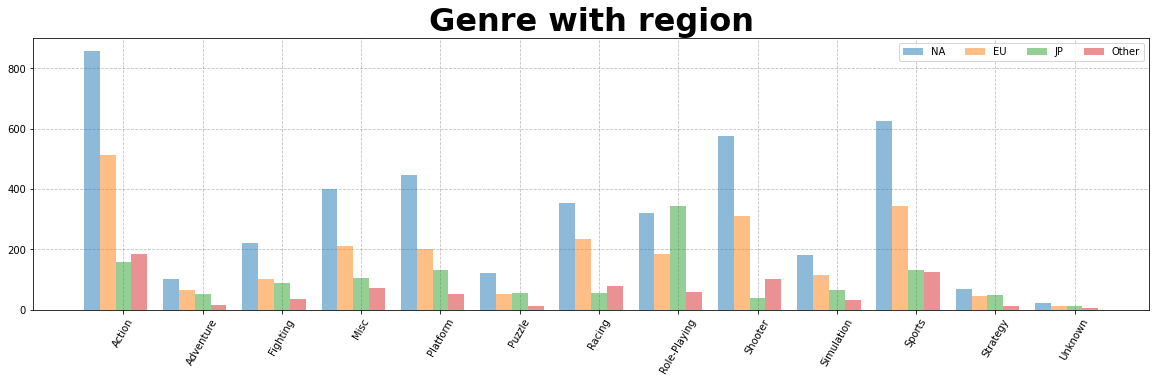

In [7]:
df_group = df.groupby('Genre')[['NA_Sales','EU_Sales','JP_Sales','Other_Sales']].sum()

fig, ax = plt.subplots(1,1, figsize=(20,5))
plt.title('Genre with region', fontdict={'fontsize' : 32, 'fontweight' : 'bold'})

colors = sns.color_palette('hls',3)
index = np.arange(df_group.shape[0])
w =0.2

plt.bar(index - 2*w , df_group['NA_Sales'], width = w, label = 'NA',alpha = 0.5)
plt.bar(index - 1*w, df_group['EU_Sales'], width = w, label = 'EU',alpha = 0.5)
plt.bar(index , df_group['JP_Sales'], width = w, label = 'JP',alpha = 0.5)
plt.bar(index + w, df_group['Other_Sales'], width = w, label = 'Other',alpha = 0.5)

plt.legend(ncol = 4)
plt.xticks(index, df_group.index, rotation = 60)
plt.grid(True,color = 'gray', alpha = 0.5, linestyle ='--')
ax.set_axisbelow(True)

plt.show()

##지역별 장르별 선호도 (원 그래프)

In [8]:
# pct를 10 이하는 표현하지 않음.

def custom_auto(pct):
  return('%.0f%%' % pct) if pct >=10 else ''

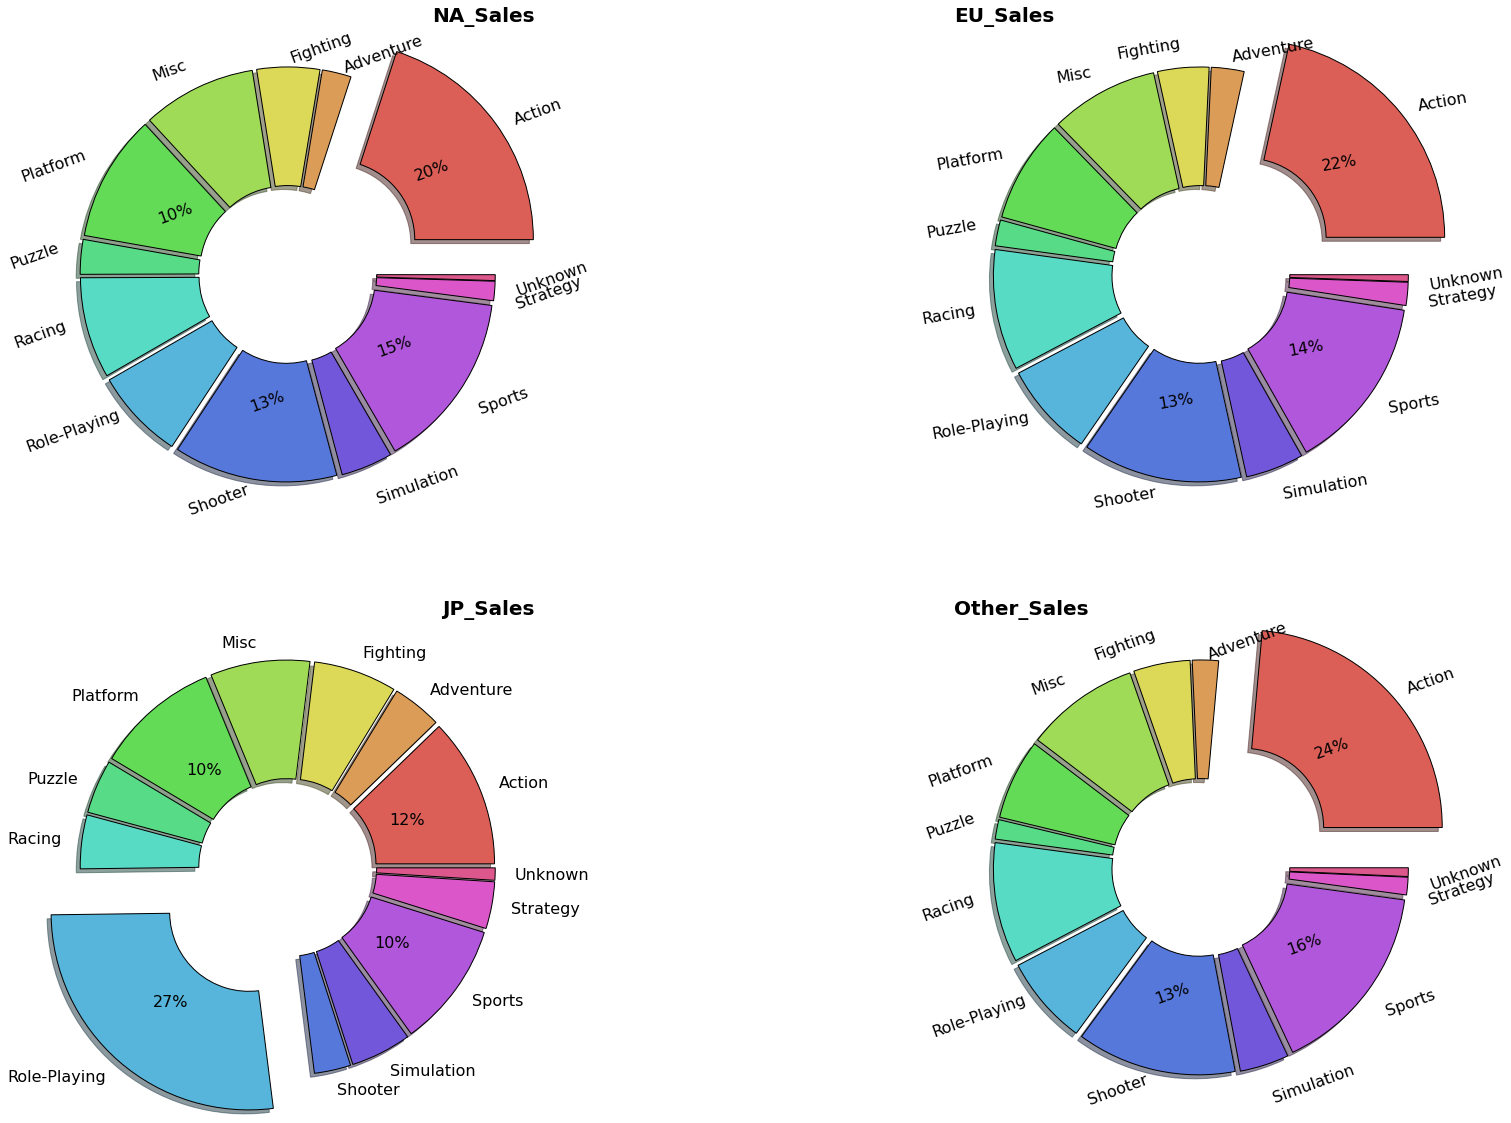

In [9]:
fig, axes = plt.subplots(2,2, figsize = (30, 20))
colors = sns.color_palette('hls',13)
wedgeprops = {'width': 0.6, 'linewidth': 1, 'edgecolor': 'black'}

plt.subplot(2,2,1)
plt.title('NA_Sales', fontdict={'fontsize' : 20, 'fontweight' : 'bold'}, loc = 'right')
explode = pd.Series([0.3,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05])
plt.pie(df_group['NA_Sales'], labels = df_group.index, 
        autopct = custom_auto, wedgeprops = wedgeprops, 
        explode = explode, colors = colors, shadow = True, textprops = {'size' : 16, 'rotation' : 20})

plt.subplot(2,2,2)
plt.title('EU_Sales', fontdict={'fontsize' : 20, 'fontweight' : 'bold'}, loc = 'left')
explode = pd.Series([0.3,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05])
plt.pie(df_group['EU_Sales'], colors = colors, labels = df_group.index, autopct = custom_auto, wedgeprops = wedgeprops, explode = explode, shadow = True,textprops = {'size' : 16, 'rotation' : 10
})

plt.subplot(2,2,3)
plt.title('JP_Sales', fontdict={'fontsize' : 20, 'fontweight' : 'bold'}, loc = 'right')
explode = pd.Series([0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.3,0.05,0.05,0.05,0.05,0.05])
plt.pie(df_group['JP_Sales'], colors = colors, labels = df_group.index, autopct = custom_auto, wedgeprops = wedgeprops, explode = explode, shadow = True,textprops = {'size' : 16})

plt.subplot(2,2,4)
plt.title('Other_Sales', fontdict={'fontsize' : 20, 'fontweight' : 'bold'}, loc = 'left')
explode = pd.Series([0.3,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05])
plt.pie(df_group['Other_Sales'], colors = colors, labels = df_group.index, autopct = custom_auto, wedgeprops = wedgeprops, explode = explode, shadow = True,textprops = {'size' : 16, 'rotation' : 20})

plt.show()


## 연도별 게임 트렌드 추세

### Platform 별 트렌드

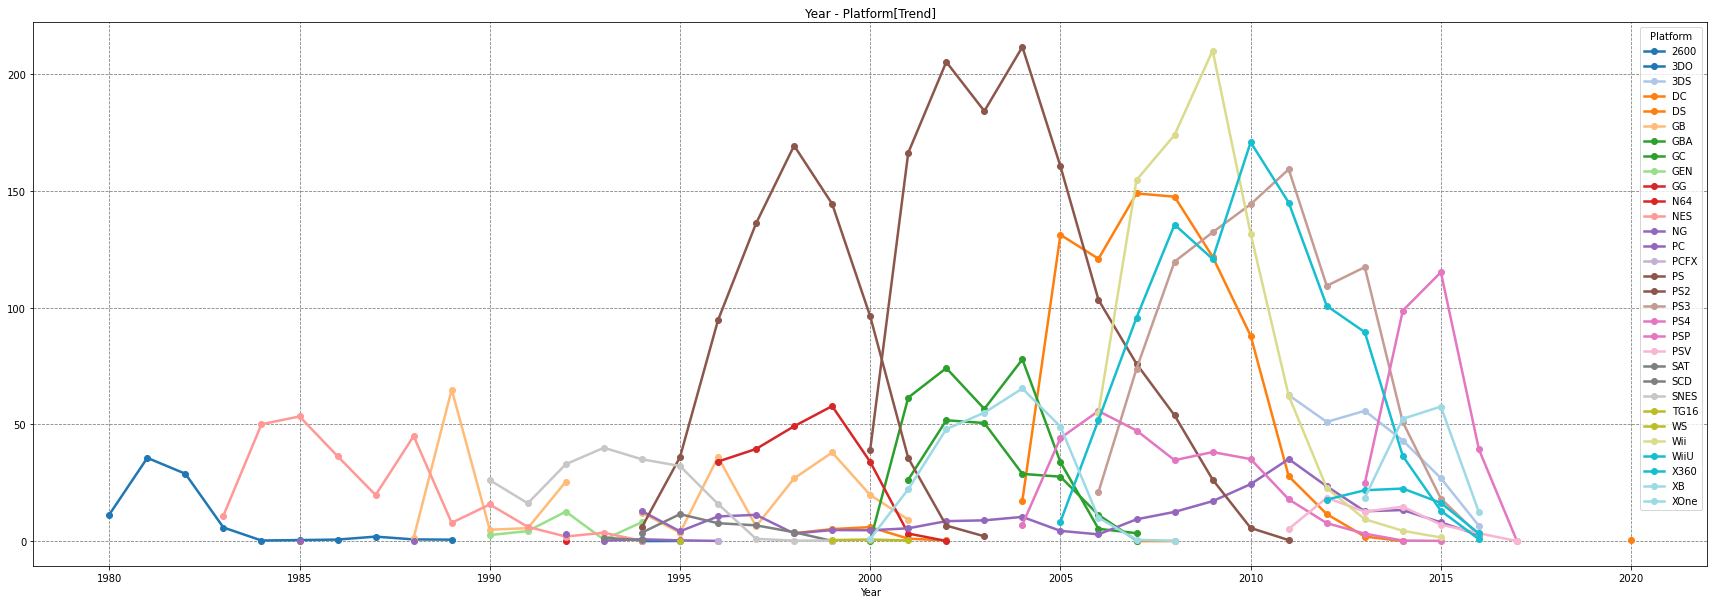

In [10]:
df_y = df.groupby(['Year','Platform']).sum()
df_y.groupby(['Year','Platform'])['sum'].sum().unstack().plot(figsize = (30,10), marker = 'o', colormap ='tab20', linewidth = 2.5, title = 'Year - Platform[Trend]')

plt.grid(color = 'gray', linestyle = '--')

Text(0.5, 1.0, 'Year - Platform')

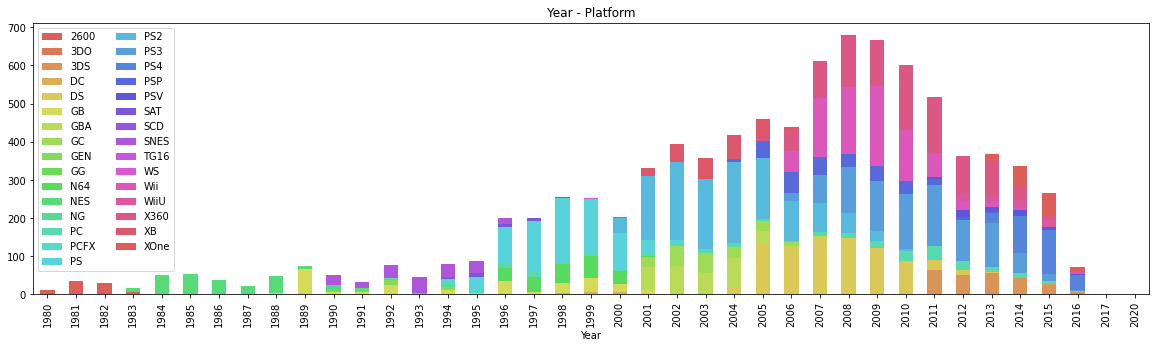

In [11]:
df_yp = df.groupby(['Year','Platform'])['sum'].sum()
df_yp = pd.DataFrame(df_yp)
colors = sns.color_palette('hls',30)
df_yp.reset_index(drop=False, inplace = True)

pivot_yp = df_yp.pivot(index = 'Year', columns = 'Platform', values = 'sum')
pivot_yp = pivot_yp[['2600', '3DO', '3DS', 'DC', 'DS', 'GB', 'GBA', 'GC', 'GEN', 'GG', 'N64',
       'NES', 'NG', 'PC', 'PCFX', 'PS', 'PS2', 'PS3', 'PS4', 'PSP', 'PSV',
       'SAT', 'SCD', 'SNES', 'TG16', 'WS', 'Wii', 'WiiU', 'X360', 'XB',
       'XOne']].copy()
pivot_yp.fillna(0, inplace = True)
pivot_yp.plot.bar(stacked = True, figsize = (20,5), color = colors)
plt.legend(ncol = 2)
plt.title('Year - Platform')

### Genre 별 트렌드

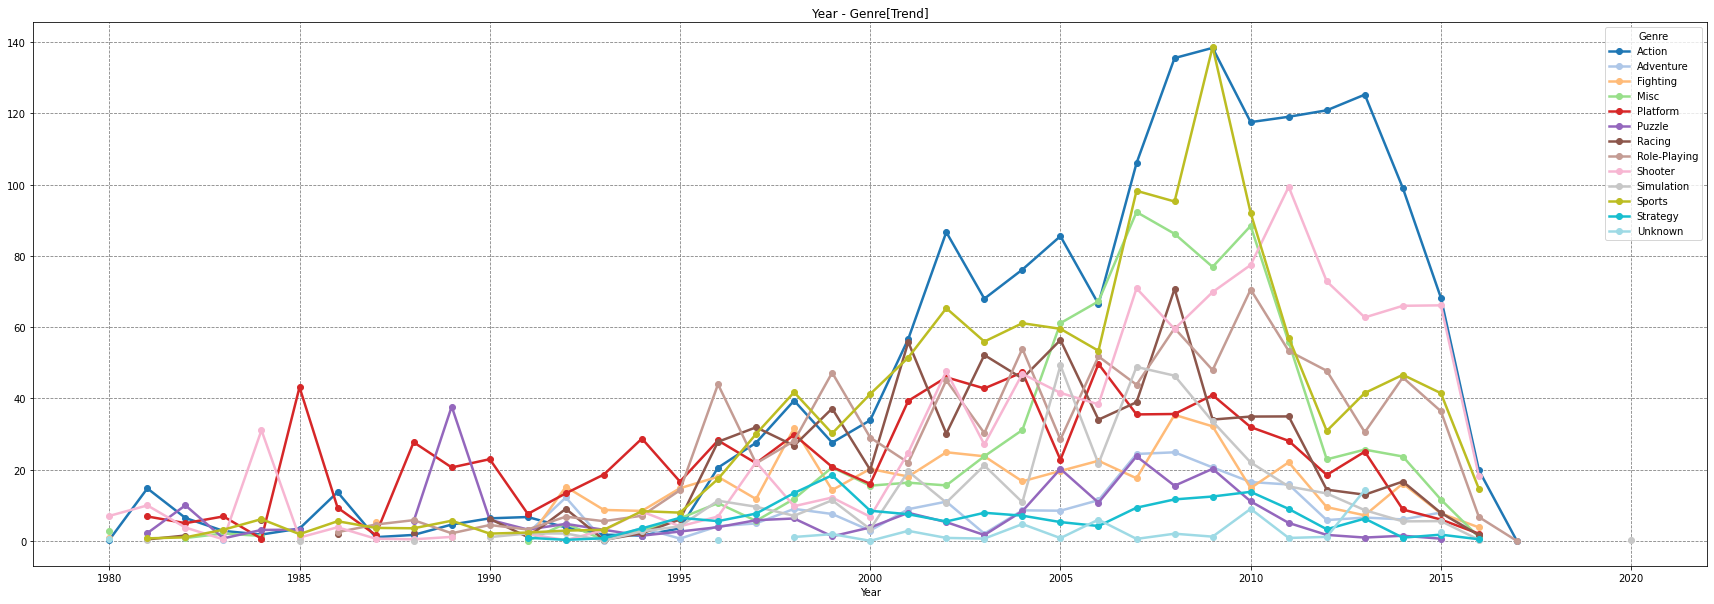

In [12]:
df_y = df.groupby(['Year','Genre']).sum()
df_y.groupby(['Year','Genre'])['sum'].sum().unstack().plot(figsize = (30,10), marker = 'o', colormap ='tab20', linewidth = 2.5, title = 'Year - Genre[Trend]')

plt.grid(color = 'gray', linestyle = '--')

Text(0.5, 1.0, 'Year - Genre')

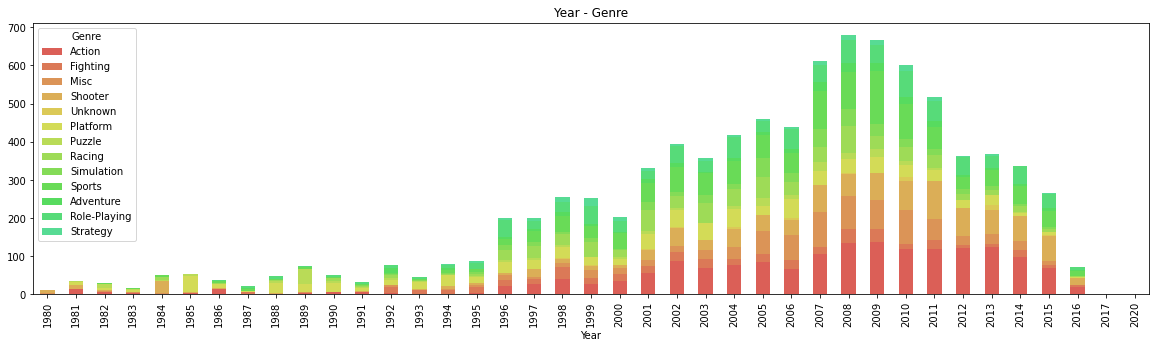

In [13]:
df_kk = df.groupby(['Year','Genre'])['sum'].sum()
df_kk = pd.DataFrame(df_kk)
df_kk.reset_index(drop=False, inplace = True)

pivot_df = df_kk.pivot(index = 'Year', columns = 'Genre', values = 'sum')
pivot_df = pivot_df[['Action', 'Fighting', 'Misc', 'Shooter', 'Unknown', 'Platform',
       'Puzzle', 'Racing', 'Simulation', 'Sports', 'Adventure',
       'Role-Playing', 'Strategy']].copy()
pivot_df.fillna(0, inplace = True)
pivot_df.plot.bar(stacked = True, figsize = (20,5), color = colors)
plt.title('Year - Genre')

### 상위 5개 장르에 대한 연도별 추세

In [14]:
condition = (df.Genre == 'Action') | (df.Genre == 'Role-Playing') | (df.Genre == 'Misc') | (df.Genre == 'Sports') | (df.Genre == 'Shooter')  
df_G = df[condition]

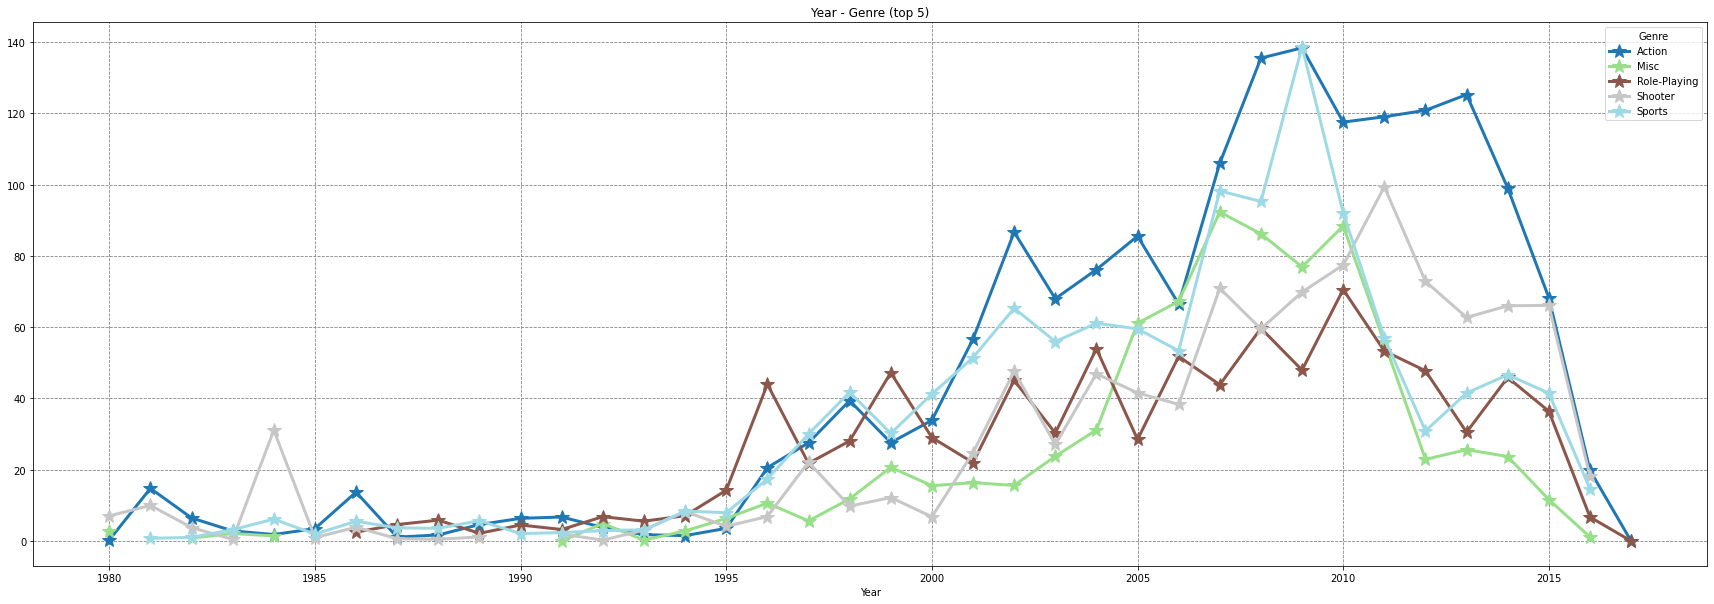

In [15]:
df_G.groupby(['Year','Genre'])['sum'].sum().unstack().plot(figsize = (30,10), colormap ='tab20', linewidth = 3, marker = '*', markersize=15, title = 'Year - Genre (top 5)')
plt.grid(color = 'gray', linestyle = '--')

Text(0.5, 1.0, 'Year - 5 Genres')

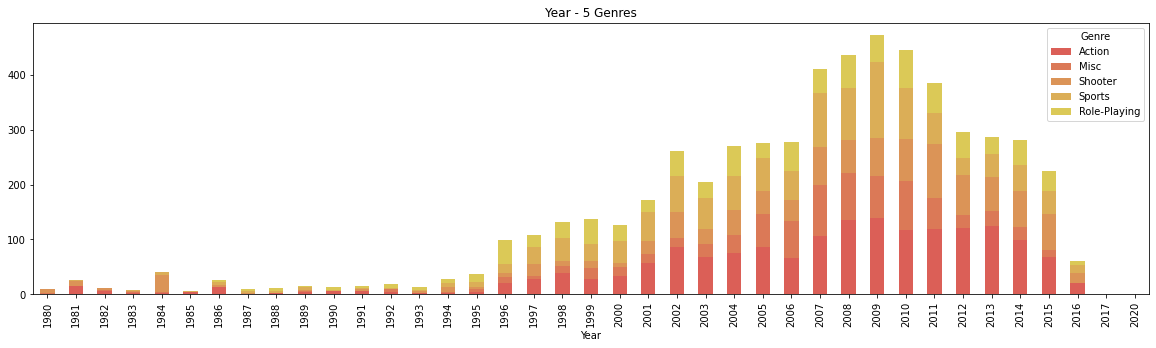

In [16]:
df_trend5 = df_G.groupby(['Year','Genre'])['sum'].sum()
df_trend5 = pd.DataFrame(df_kk)
df_trend5.reset_index(drop=False, inplace = True)

pivot_df = df_trend5.pivot(index = 'Year', columns = 'Genre', values = 'sum')
pivot_df = pivot_df[['Action', 'Misc', 'Shooter', 'Sports', 'Role-Playing']].copy()
pivot_df.fillna(0, inplace = True)
pivot_df.plot.bar(stacked = True, figsize = (20,5), color = colors)
plt.title('Year - 5 Genres')

## 상위 100개 게임에 대한 분석

In [17]:
df_pop = df.sort_values(by=['sum'], axis = 0, ascending = False)
df_pop = df_pop.iloc[:100,:]

### 상위 100개 게임에 대한 platform 과 Genre 분석





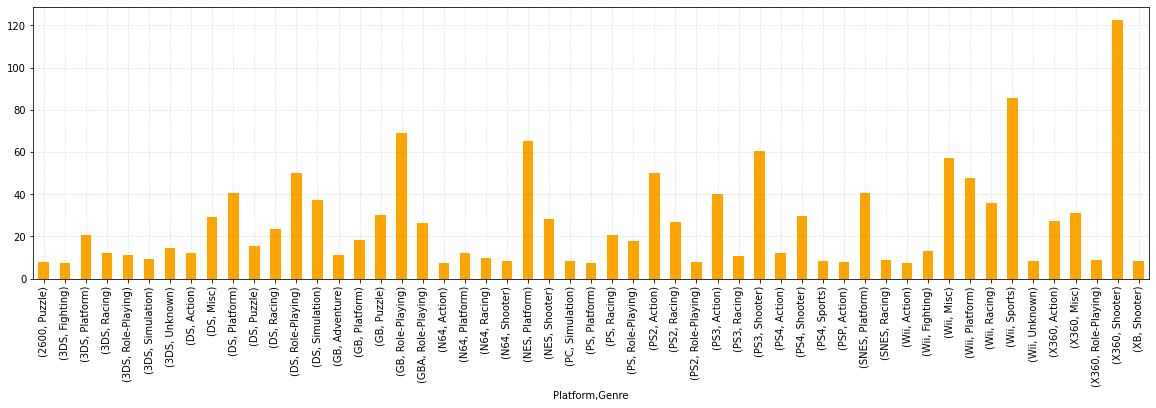

In [18]:
df_platform = df_pop.groupby(['Platform','Genre'])['sum'].sum()
df_platform.plot.bar(figsize=(20,5), color = 'orange', alpha = 1)
plt.grid(color = 'gray' , linestyle = '--', alpha = 0.2)

### 상위 100개 게임에 대한 장르별 총 판매량 분석

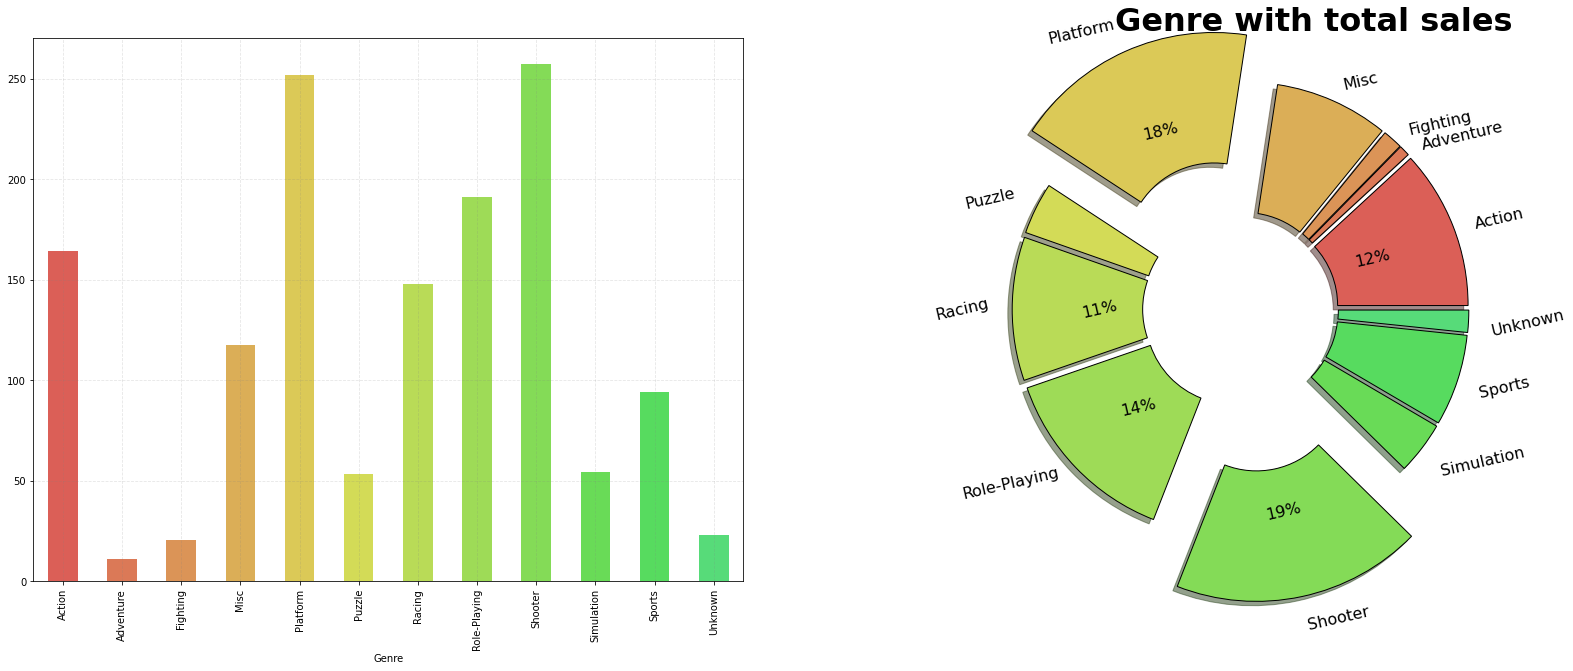

In [19]:
df_genre = df_pop.groupby(['Genre'])['sum'].sum()

explode = pd.Series([0.05,0.05,0.05,0.05,0.3,0.05,0.05,0.05,0.35,0.05,0.05,0.05])

plt.subplot(1,2,1)
df_genre.plot.bar(figsize = (28, 10), color = colors, alpha = 1)
plt.grid(color = 'gray' , linestyle = '--', alpha = 0.2)

plt.subplot(1,2,2)
plt.title('Genre with total sales', loc = 'right', fontdict={'fontsize' : 32, 'fontweight' : 'bold'})
plt.pie(df_genre, labels = df_genre.index, autopct = custom_auto, wedgeprops = wedgeprops, 
        explode = explode, colors = colors, textprops = {'size' : 16, 'rotation': 13} ,shadow = True)


plt.show()

### 상위 100개 게임에 대한 제작사별 총 판매량 분석

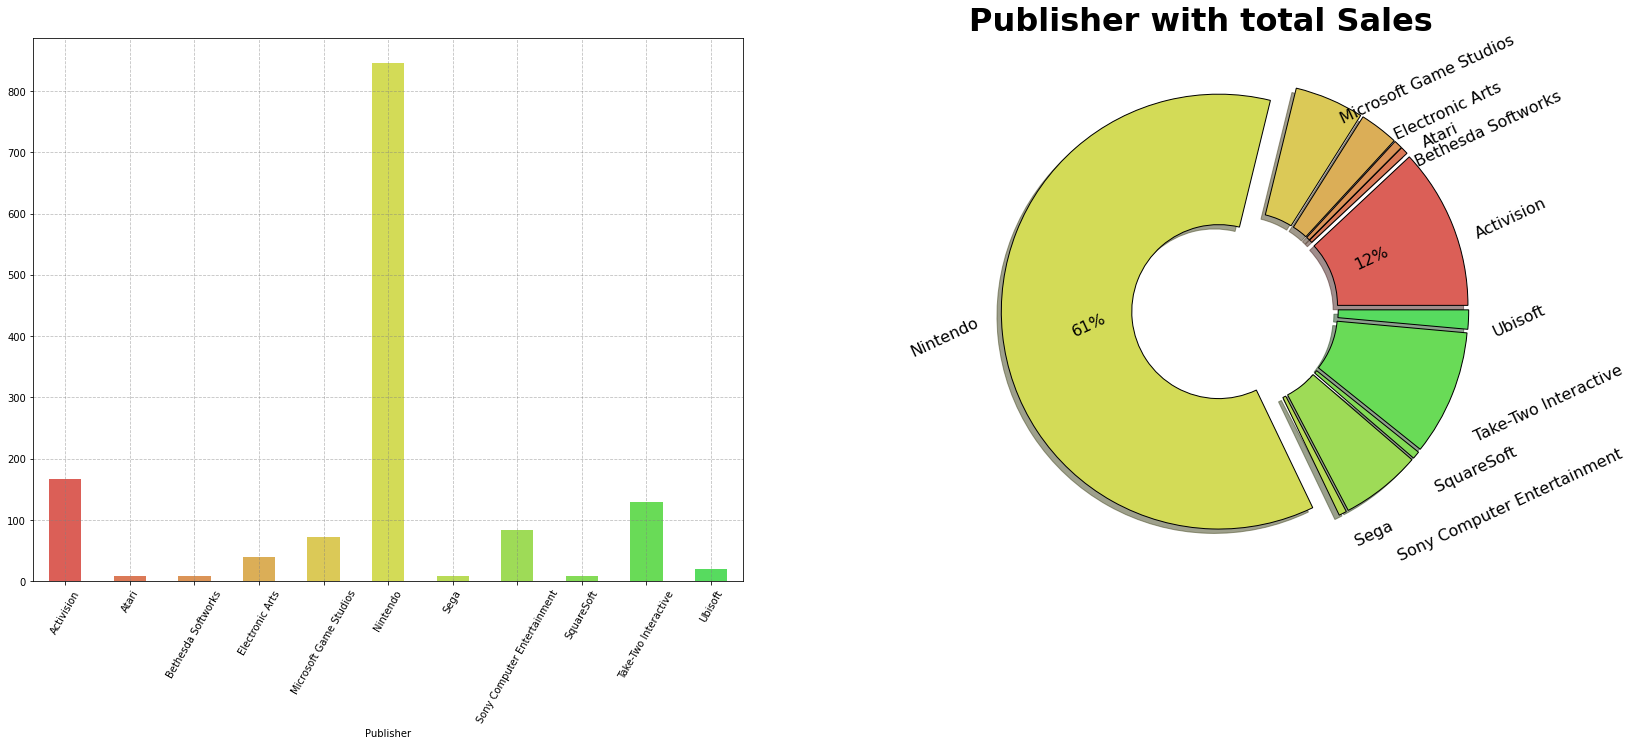

In [20]:
df_publisher = df_pop.groupby(['Publisher'])['sum'].sum()

explode = pd.Series([0.05,0.05,0.05,0.05,0.05,0.1,0.05,0.05,0.05,0.05,0.05])

plt.subplot(1,2,1)
df_publisher.plot.bar(figsize = (28,10), color = colors)
plt.xticks(rotation = 60)
plt.grid(color = 'gray', linestyle = '--', alpha = 0.5)

plt.subplot(1,2,2)
plt.title('Publisher with total Sales', loc = 'left', fontdict={'fontsize' : 32, 'fontweight' : 'bold'})
plt.pie(df_publisher, labels = df_publisher.index, autopct = custom_auto, wedgeprops = wedgeprops, 
        explode = explode, colors = colors, textprops = {'size' : 16, 'rotation' : 25} ,shadow = True)

plt.show()

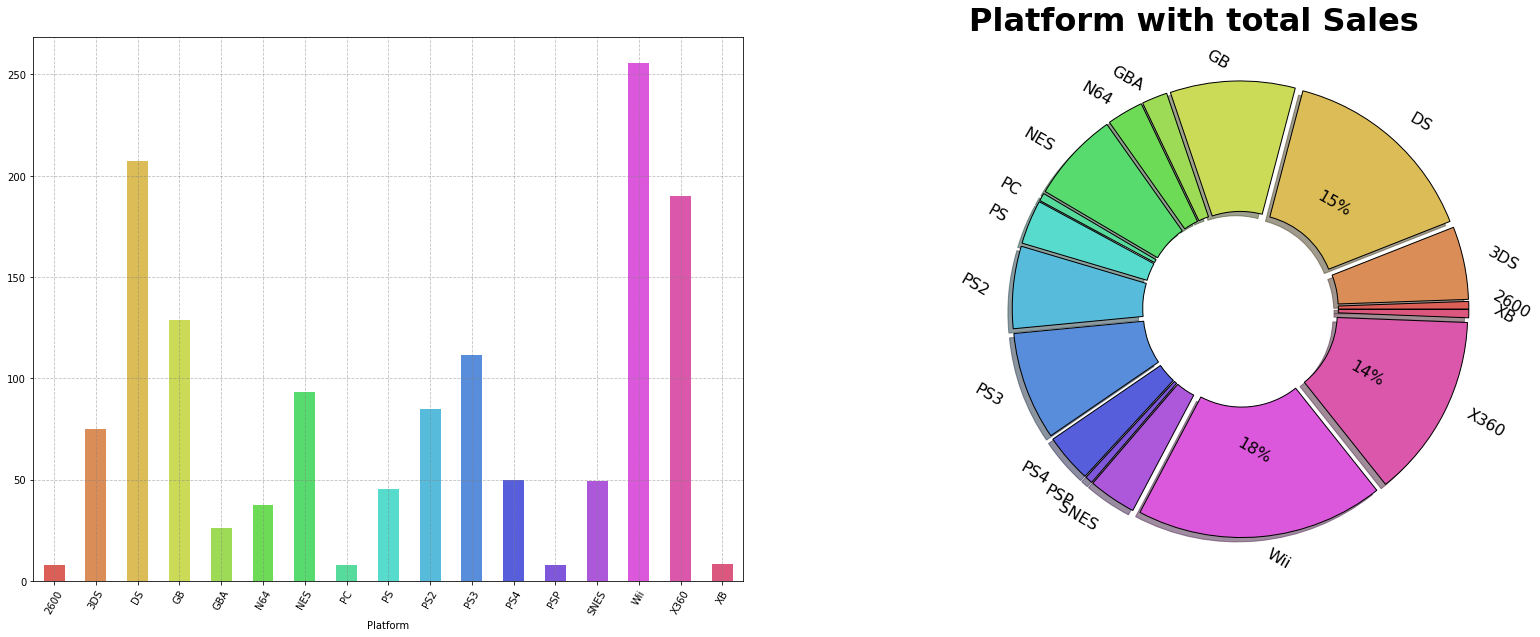

In [21]:
df_Platform = df_pop.groupby(['Platform'])['sum'].sum()
colors = sns.color_palette('hls',17)
plt.grid(color = 'gray', linestyle = '--', alpha = 0.5)

explode = pd.Series([0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05])

plt.subplot(1,2,1)
df_Platform.plot.bar(figsize = (28,10), color = colors)
plt.xticks(rotation = 60)
plt.grid(color = 'gray', linestyle = '--', alpha = 0.5)

plt.subplot(1,2,2)
plt.title('Platform with total Sales', loc = 'left', fontdict={'fontsize' : 32, 'fontweight' : 'bold'})
plt.pie(df_Platform, labels = df_Platform.index, autopct = custom_auto, wedgeprops = wedgeprops, 
        explode = explode, colors = colors, textprops = {'size' : 16, 'rotation' : -30} ,shadow = True)

plt.show()

## 총 판매량 기준 상위 100개, 500개, 1000개로 등급을 나누어 분석 진행

In [22]:
df_total = df.sort_values(by=['sum'], axis = 0, ascending = False)
df_total.reset_index(drop = True, inplace = True)
df_total = df_total.iloc[:1001, : ]

conditionlist = [
    (df_total.index <= 100) ,
    (df_total.index <= 500) & (df_total.index <300),
    (df_total.index <= 1000)]
choicelist = ['A', 'B', 'C']

df_total['Grade'] = np.select(conditionlist, choicelist, default='Not Specified')

In [23]:
df_total[df_total['Grade'] == 'A'].tail()

,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,sum,Grade
96,Super Smash Bros. for Wii U and 3DS,3DS,2014,Fighting,Nintendo,3.24,1.35,2.42,0.43,7.44,A
97,Call of Duty: World at War,X360,2008,Shooter,Activision,4.79,1.90,0.00,0.69,7.38,A
98,Battlefield 3,X360,2011,Shooter,Electronic Arts,4.46,2.13,0.06,0.69,7.34,A
99,The Legend of Zelda: Twilight Princess,Wii,2006,Action,Nintendo,3.83,2.19,0.60,0.70,7.32,A
100,Call of Duty: Black Ops 3,XOne,2015,Shooter,Activision,4.52,2.09,0.01,0.67,7.29,A


## 장르별 총판매량에 따른 분석

Text(0.5, 1.0, 'Genre with Sum')

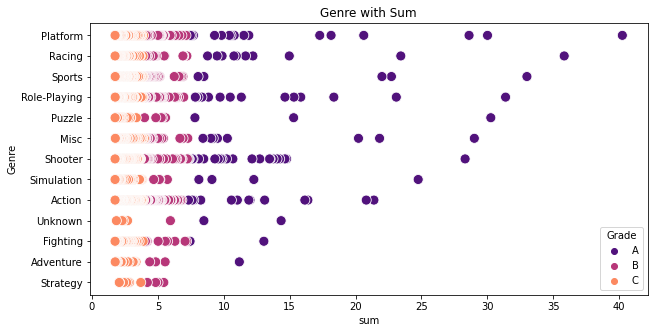

In [24]:
plt.figure(figsize = (10,5))
sns.scatterplot(data=df_total, hue = 'Grade', x ='sum',y='Genre', palette = 'magma', s= 100)
plt.title('Genre with Sum')

## 제작사 별 총 판매량에 따른 분석

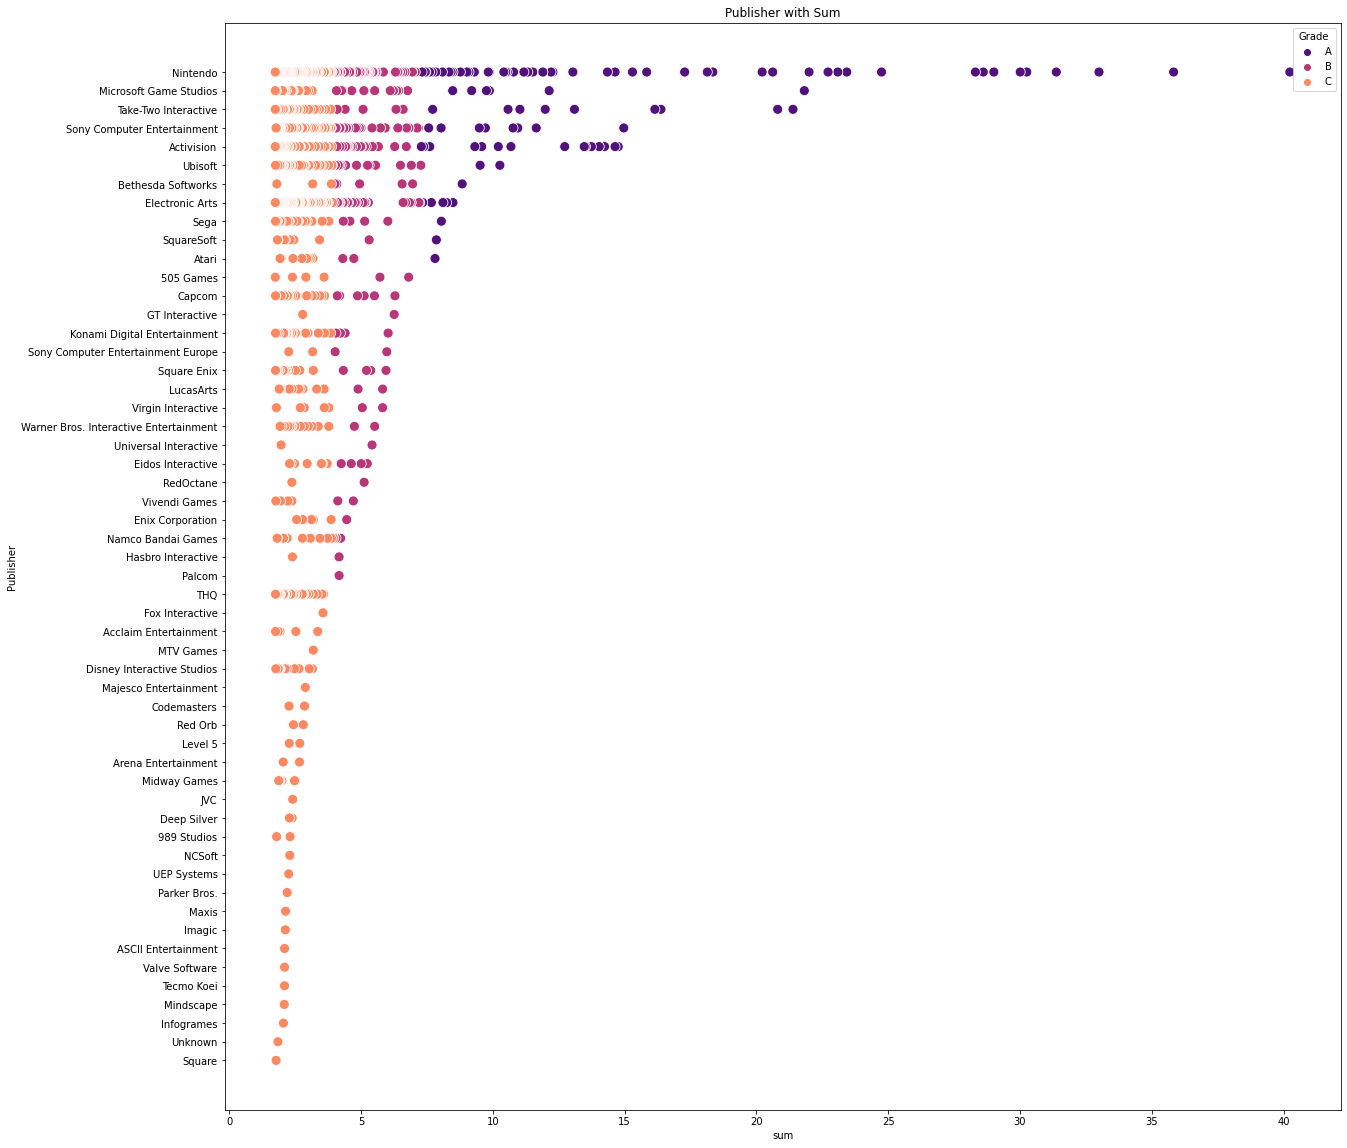

In [25]:
plt.figure(figsize = (20,20))
sns.scatterplot(data=df_total, hue = 'Grade', x ='sum', y='Publisher', palette = 'magma', s= 100)
plt.title('Publisher with Sum')
plt.savefig('savefig_default.png')

## platform에 따른 총 판매량 분석

Text(0.5, 1.0, 'Platform with Sum')

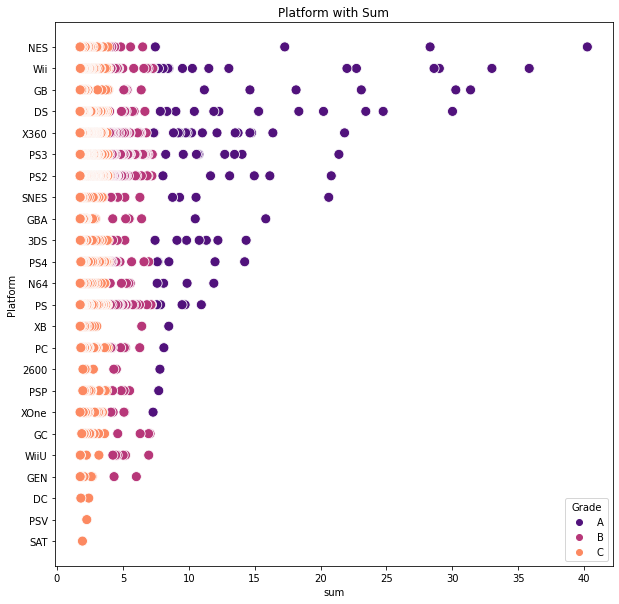

In [26]:
plt.figure(figsize = (10,10))
sns.scatterplot(data=df_total, hue = 'Grade', y ='Platform', x ='sum', palette = 'magma', s= 100)
plt.title('Platform with Sum')

## 지역별 시장 규모

In [27]:
df_na = df
df_na.sort_values(by=['NA_Sales'], axis = 0, ascending = False, inplace = True)
df_na.reset_index(drop = True, inplace = True)
df_nasales = df_na.loc[:,'NA_Sales':'Other_Sales']
df_salesbig = df_nasales.T
df_salesbig['sum_region'] = df_salesbig.sum(axis = 1)

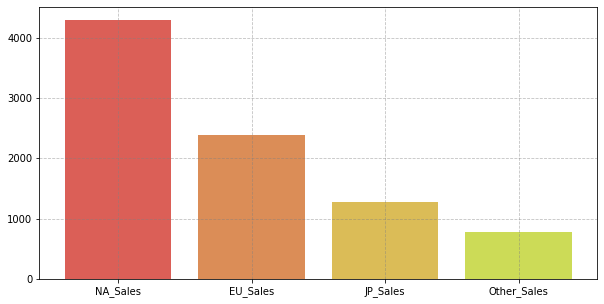

In [28]:
plt.figure(figsize = (10,5))
plt.bar(df_salesbig.index, df_salesbig['sum_region'], color = colors)
plt.grid(color = 'gray', linestyle = '--', alpha = 0.5)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  


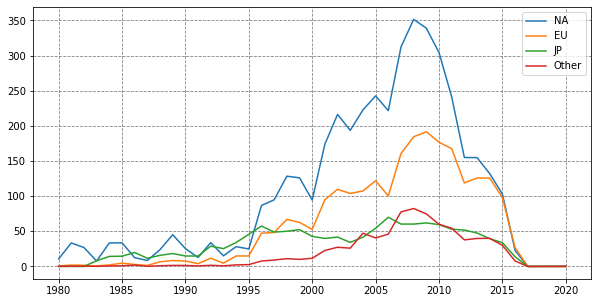

In [29]:
plt.figure(figsize = (10,5))
df_region = df.groupby('Year')['NA_Sales','EU_Sales','JP_Sales','Other_Sales'].sum()
plt.plot(df_region)
label = ['NA','EU','JP','Other']
plt.grid(color = 'gray', linestyle = '--')
plt.legend(label)
plt.show()

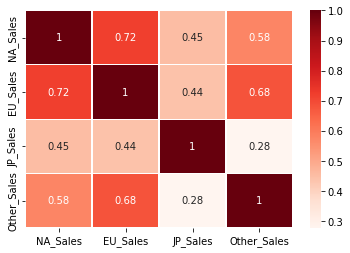

In [30]:
df_heat = df.loc[:,'NA_Sales':'Other_Sales']
sns.heatmap(df_heat.corr(),annot=True,linewidths=0.2,cmap='Reds')
plt.show()

## 상위 100개 게임에 대해서 제작사를 기준으로 분석

/usr/local/lib/python3.7/dist-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


Text(0.5, 1.0, 'Year - Platform')

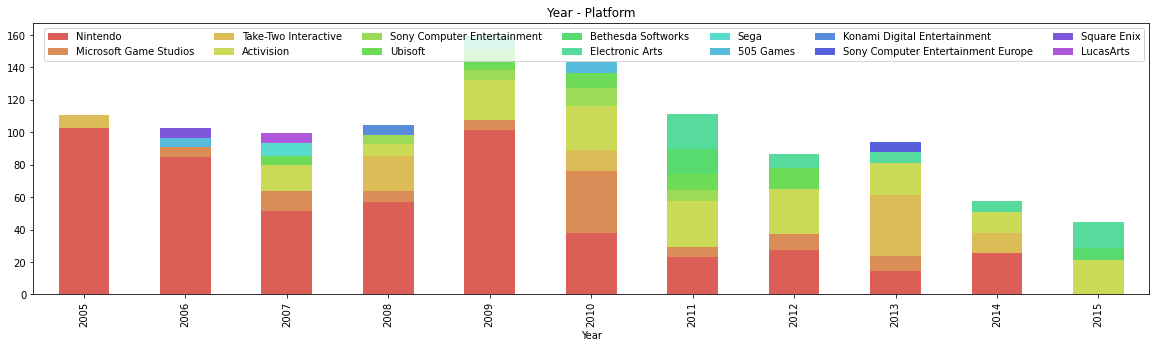

In [31]:
df_2005 = df[df['Year'] >= 2005]
df_2005.sort_values(by='sum', ascending = False, inplace = True)
df_2005.reset_index(inplace = True, drop = True)
df_2005 = df_2005.iloc[:100,:]
df_2005_g = pd.DataFrame(df_2005.groupby(['Year','Publisher'])['sum'].sum())
df_2005_g.reset_index(drop=False, inplace = True)

pivot_2005_g = df_2005_g.pivot(index = 'Year', columns = 'Publisher', values = 'sum')
pivot_2005_g = pivot_2005_g[['Nintendo', 'Microsoft Game Studios', 'Take-Two Interactive',
       'Activision', 'Sony Computer Entertainment', 'Ubisoft',
       'Bethesda Softworks', 'Electronic Arts', 'Sega', '505 Games',
       'Konami Digital Entertainment',
       'Sony Computer Entertainment Europe', 'Square Enix', 'LucasArts']].copy()
pivot_2005_g.fillna(0, inplace = True)
pivot_2005_g.plot.bar(stacked = True, figsize = (20,5), color = colors)
plt.legend(ncol = 7)
plt.title('Year - Platform')

In [32]:
df_na = df_na[df_na['NA_Sales'] != 0]
df_pop = df_na.sort_values(by=['NA_Sales'], axis = 0, ascending = False)
df_pop = df_pop.iloc[:100,:]

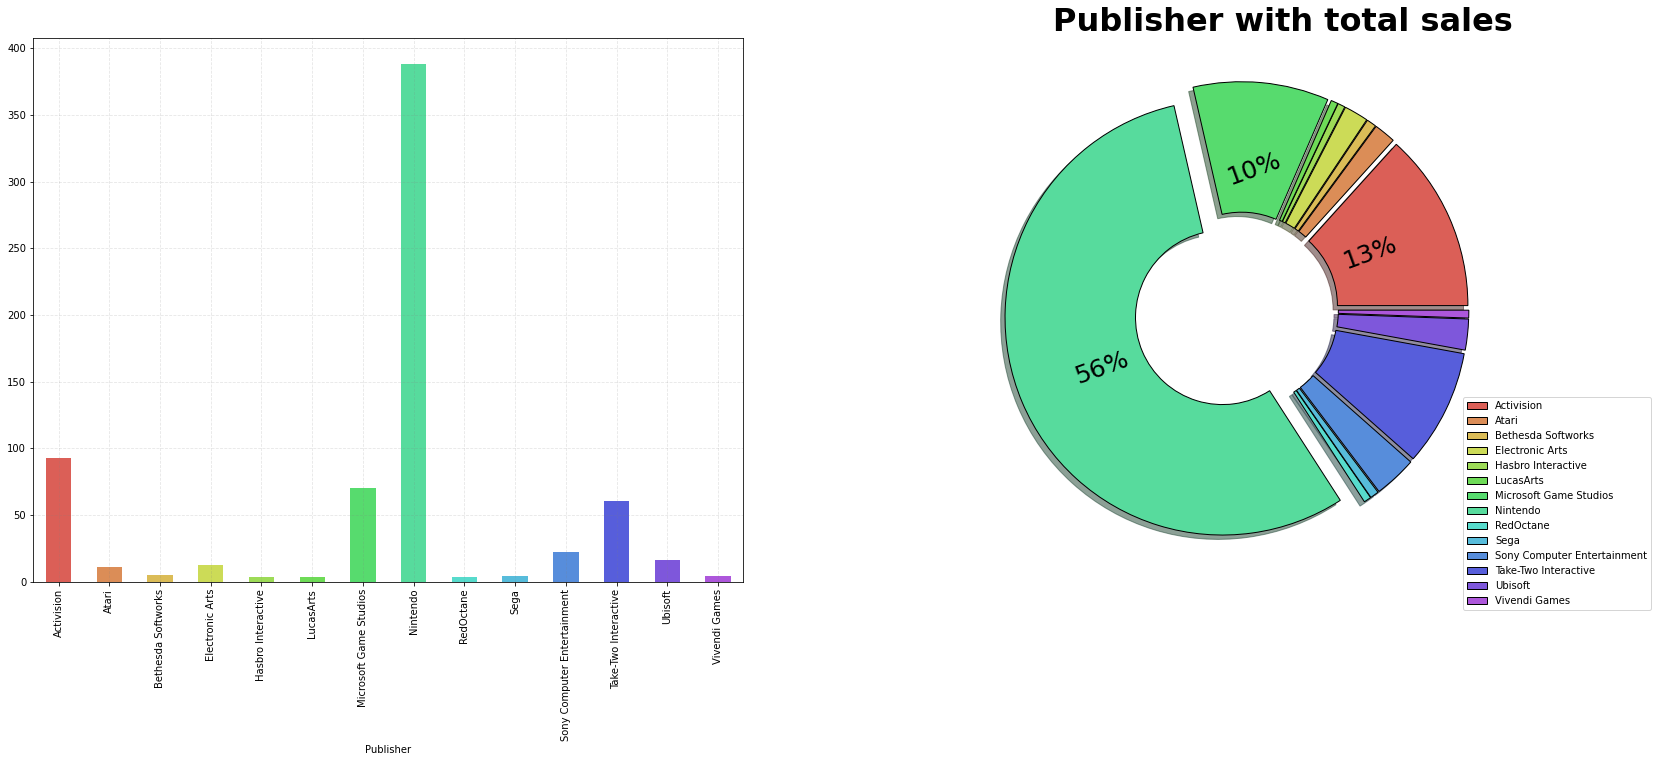

In [33]:
df_publisher_na = df_pop.groupby(['Publisher'])['NA_Sales'].sum()

explode = pd.Series([0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.09,0.05,0.05,0.05,0.05,0.05,0.05])

plt.subplot(1,2,1)
df_publisher_na.plot.bar(figsize = (28, 10), color = colors, alpha = 1)
plt.grid(color = 'gray' , linestyle = '--', alpha = 0.2)

plt.subplot(1,2,2)
plt.title('Publisher with total sales', loc = 'right', fontdict={'fontsize' : 32, 'fontweight' : 'bold'})
plt.pie(df_publisher_na, autopct = custom_auto, wedgeprops = wedgeprops, 
        explode = explode, colors = colors, textprops = {'size' : 25, 'rotation': 20} ,shadow = True)

labelname = df_publisher_na.index
plt.legend(labelname, loc = 'upper left', bbox_to_anchor=(0.9,0.35))

plt.show()

In [34]:
df_Ntd = df_na[df_na['Publisher'] == 'Nintendo']

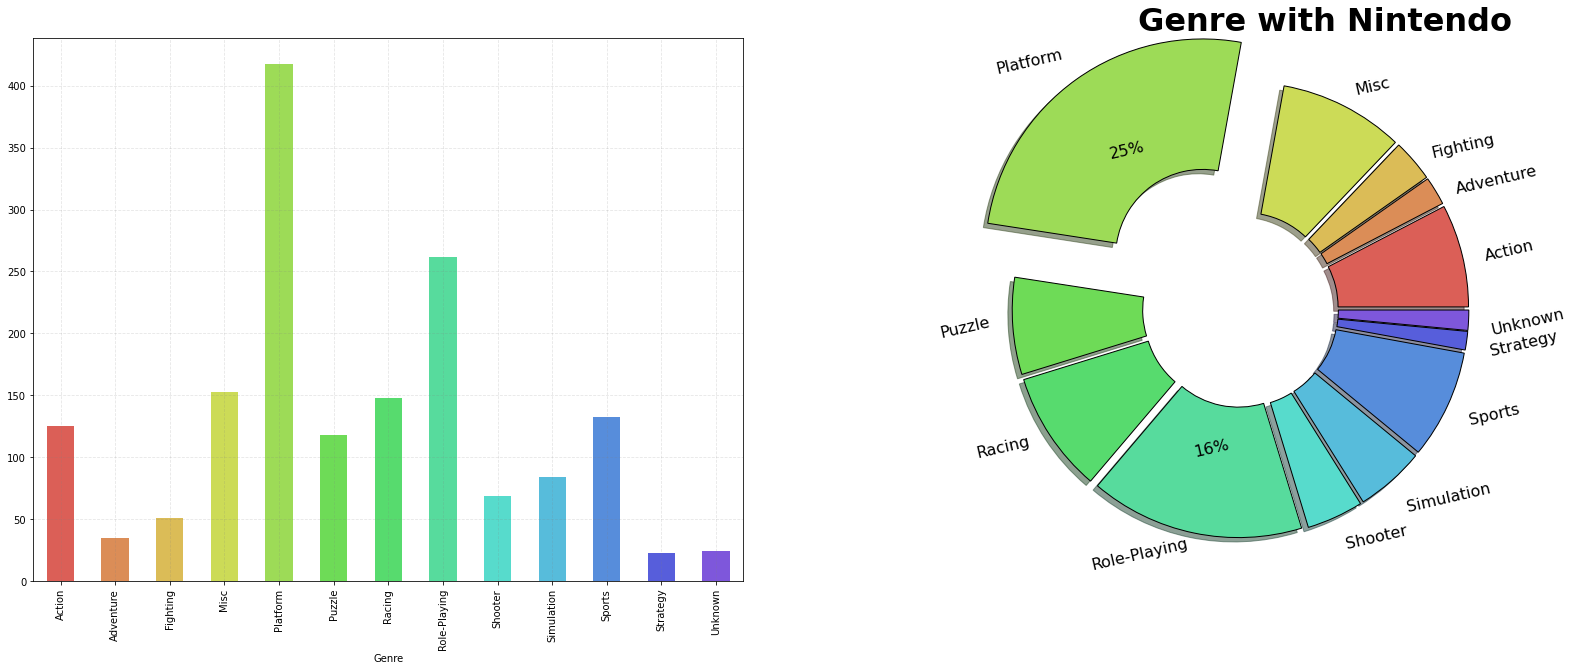

In [35]:
df_nintendo = df_Ntd.groupby(['Genre'])['sum'].sum()

explode = pd.Series([0.05,0.05,0.05,0.05,0.3,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05])

plt.subplot(1,2,1)
df_nintendo.plot.bar(figsize = (28, 10), color = colors, alpha = 1)
plt.grid(color = 'gray' , linestyle = '--', alpha = 0.2)

plt.subplot(1,2,2)
plt.title('Genre with Nintendo', loc = 'right', fontdict={'fontsize' : 32, 'fontweight' : 'bold'})
plt.pie(df_nintendo, labels = df_nintendo.index, autopct = custom_auto, wedgeprops = wedgeprops, 
        explode = explode, colors = colors, textprops = {'size' : 16, 'rotation': 13} ,shadow = True)


plt.show()

In [36]:
df_ntdplat = df_Ntd[(df_Ntd['Genre'] == 'Platform') & (df_Ntd['Publisher'] == 'Nintendo') & (df_Ntd['Year'] >= 2010)]

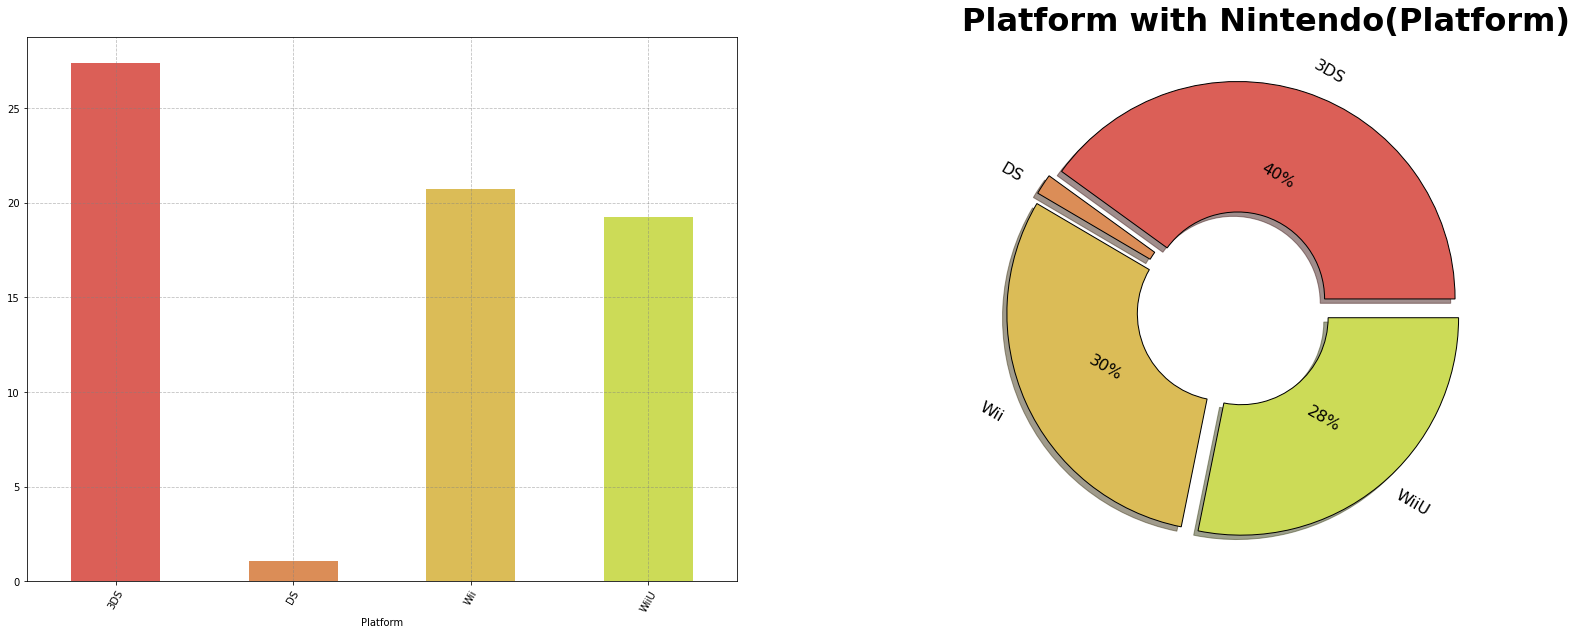

In [37]:
df_Platform = df_ntdplat.groupby(['Platform'])['sum'].sum()
colors = sns.color_palette('hls',17)
plt.grid(color = 'gray', linestyle = '--', alpha = 0.5)

explode = pd.Series([0.05,0.05,0.05,0.05])

plt.subplot(1,2,1)
df_Platform.plot.bar(figsize = (28,10), color = colors)
plt.xticks(rotation = 60)
plt.grid(color = 'gray', linestyle = '--', alpha = 0.5)

plt.subplot(1,2,2)
plt.title('Platform with Nintendo(Platform)', loc = 'left', fontdict={'fontsize' : 32, 'fontweight' : 'bold'})
plt.pie(df_Platform, labels = df_Platform.index, autopct = custom_auto, wedgeprops = wedgeprops, 
        explode = explode, colors = colors, textprops = {'size' : 16, 'rotation' : -30} ,shadow = True)

plt.show()

In [38]:
df[df['Platform'] == 'WiiU'].sort_values(by='Year', ascending = True) # 시장 판매기간 조사

,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,sum
6581,WipeOut 3 The Game,WiiU,2012,Action,Activision,0.12,0.00,0.00,0.01,0.13
8336,Darksiders II,WiiU,2012,Action,THQ,0.07,0.07,0.00,0.01,0.15
8068,NBA 2K13,WiiU,2012,Sports,Take-Two Interactive,0.08,0.04,0.00,0.01,0.13
7801,Game Party: Champions,WiiU,2012,Action,Warner Bros. Interactive Entertainment,0.09,0.03,0.00,0.01,0.13
7456,Tekken Tag Tournament 2,WiiU,2012,Fighting,Namco Bandai Games,0.09,0.07,0.01,0.01,0.18
...,...,...,...,...,...,...,...,...,...,...
13332,Terraria,WiiU,2016,Action,505 Games,0.00,0.02,0.00,0.00,0.02
6408,LEGO Marvel's Avengers,WiiU,2016,Action,Warner Bros. Interactive Entertainment,0.12,0.09,0.00,0.02,0.23
9986,Lego Star Wars: The Force Awakens,WiiU,2016,Action,Warner Bros. Interactive Entertainment,0.04,0.04,0.00,0.01,0.09
5417,Star Fox: Zero,WiiU,2016,Shooter,Nintendo,0.16,0.10,0.07,0.03,0.36


In [39]:
df[df['Platform'] == 'Wii'].sort_values(by='Year', ascending = True)

,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,sum
6389,Happy Feet,Wii,2006,Action,Midway Games,0.12,0.00,0.00,0.01,0.13
7298,Tom Clancy's Splinter Cell: Double Agent,Wii,2006,Action,Ubisoft,0.10,0.01,0.00,0.01,0.12
4360,Bleach: Shattered Blade,Wii,2006,Fighting,Sega,0.22,0.01,0.08,0.02,0.33
5860,Super Swing Golf,Wii,2006,Sports,Nintendo,0.14,0.01,0.07,0.01,0.23
12920,Shin Chan: Las Nuevas Aventuras Para Wii!,Wii,2006,Action,505 Games,0.00,0.00,0.07,0.00,0.07
...,...,...,...,...,...,...,...,...,...,...
13619,Disney Planes Fire & Rescue,Wii,2014,Action,Disney Interactive Studios,0.00,0.05,0.00,0.00,0.05
1953,Just Dance 2016,Wii,2015,Misc,Ubisoft,0.52,0.59,0.00,0.10,1.21
14330,Monster High: New Ghoul in School,Wii,2015,Action,Little Orbit,0.00,0.03,0.00,0.00,0.03
14665,Barbie and Her Sisters Puppy Rescue,Wii,2015,Action,Namco Bandai Games,0.00,0.06,0.00,0.00,0.06


In [41]:
df[df['Platform'] == '3DS'].sort_values(by='Year', ascending = True)

,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,sum
4822,Ridge Racer 3D,3DS,2011,Racing,Namco Bandai Games,0.19,0.15,0.12,0.03,0.49
5555,WWE All Stars,3DS,2011,Fighting,THQ,0.15,0.06,0.00,0.02,0.23
9572,BlazBlue: Continuum Shift II,3DS,2011,Fighting,PQube,0.05,0.01,0.04,0.01,0.11
9402,Driver: Renegade,3DS,2011,Racing,Ubisoft,0.05,0.04,0.00,0.01,0.10
9385,Cubic Ninja,3DS,2011,Platform,Ubisoft,0.05,0.04,0.00,0.01,0.10
...,...,...,...,...,...,...,...,...,...,...
12493,One Piece: Daikaizoku Coliseum,3DS,2016,Fighting,Namco Bandai Games,0.00,0.00,0.01,0.00,0.01
10961,3DS Classic Collection,3DS,2016,Misc,Sega,0.02,0.00,0.00,0.00,0.02
3768,Kirby: Planet Robobot,3DS,2016,Action,Nintendo,0.26,0.10,0.44,0.04,0.84
15944,Ace Attorney 6,3DS,2016,Adventure,Capcom,0.00,0.00,0.27,0.00,0.27
